### Regge-Wheeler-Zerilli Evolution | Adaptive Characteristic Method
**Author**: Ken Sible | **Date**: September 8, 2019

<img src="images/adaptive_figure.png" width="2236" height="1258" align="center"/>

**Adaptive Characteristic Method Algorithm**

\begin{align}
    \text{Lower Resolution: }&\psi^{(LR)}\,(n\rightarrow n+1)\\
    \text{Higher Resolution, 1: }&\psi^{(HR,1)}\,(n\rightarrow n+1/2)\\
    \text{Higher Resolution, 2: }&\psi^{(HR,2)}\,(n+1/2\rightarrow n+1)
\end{align}
~~~~
# Define Constants, Functions, and Initial Conditions
while u[n] < u_max
    # Compute ψLR, ψHR[1], ψHR[2]
    ε = maximum(abs.(ψHR[2] - ψLR))
    if ε < tol
        push(ψ, ψLR)
        push(u, u[n] + du)
        n += 1
    end
    du *= (tol/ε)^(1/2)
end
~~~~

In [1]:
include("packages/NumericDE.jl")
using PyPlot, LinearAlgebra, Main.NumericDE

function lambertw(z::Number; tol::Real=1e-8)
    z < -1/ℯ && throw(DomainError())
    f(w) = w * exp(w) - z
    df(w) = exp(w) * (w + 1)
    w = z < 1 ? z : log(z)
    f(w) == 0 && return w
    begin i = 0
        while abs(f(w)) > tol
            w += -f(w)/df(w)
            (i += 1) > 1000 && break
        end
    end
    return w
end

find(x::T, A::Vector{T}) where T = findfirst(isequal(x), A);

In [2]:
hx, ht, hu, hv = 0.2, 0.04, 0.4, 0.4
x0, x = 200, collect(-250:hx:250)
(ui, uf), (vi, vf) = (0, 300), (0, 300)

ψIS, ψFS = Float64[], Float64[]
function RK4_UV(t::Real, y::Array{<:Real}, f::Function, h::Real, args...)
    p = [0, 1/2, 1/2, 1]
    q = [0 0 0 0; 1/2 0 0 0; 0 1/2 0 0; 0 0 1 0]
    a = [1/6, 1/3, 1/3, 1/6]
    
    k1 = f(t, y, args...)
    k2 = f(t + p[2]*h, y + h*(q[2, 1]*k1), args...)
    k3 = f(t + p[3]*h, y + h*(q[3, 1]*k1 + q[3, 2]*k2), args...)
    k4 = f(t + p[4]*h, y + h*(q[4, 1]*k1 + q[4, 2]*k2 + q[4, 3]*k3), args...)
    
    y += h*(a[1]*k1 + a[2]*k2 + a[3]*k3 + a[4]*k4); t = round(t + h, digits=2)
    
    for j = 1:length(x)
        u, v = t - x[j], t + x[j]

        if (vi <= v <= vf) && u == ui
            push!(ψIS, y[j, 1])
        end
        if (ui <= u <= uf) && v == vf
            push!(ψFS, y[j, 1])
        end
    end
    return y
end

l, r_s = 3, 2 # Angular Momentum, Schwarzschild Radius
V(r) = (1 - r_s/r)*((l + 1)l/r^2 - 3r_s/r^3)
r(x) = 2(lambertw(exp((x - 2)/2)) + 1)
U = V.(r.(x)) # Vectorized Potential

function f(t, ψ)
    Nx = size(ψ)[1]
    ψxx = zeros(Nx)
    for j = 2:(Nx - 1)
        ψxx[j] = (ψ[j + 1, 1] - 2ψ[j, 1] + ψ[j - 1, 1])/hx^2
    end
    return hcat(ψ[:, 2], ψxx .- U .* ψ[:, 1])
end

g(x) = 0.5(exp(-0.1(x - x0)^2))
∂t_g(x) = 2*0.1(x0 - x) * g.(x)
ψ0 = hcat(g.(x), ∂t_g.(x))
push!(ψIS, ψ0[find(0.0, x), 1]);

# pdeint(f, (0, 300), (-250, 250), ψ0, ht, hx, method=RK4_UV)

In [3]:
function uv_uniform(uspan::NTuple{2, Real}, vspan::NTuple{2, Real},
        hu::Real, hv::Real, ψ0::Union{Function, Vector{<:Real}})
    (ui, uf), (vi, vf) = uspan, vspan
    u, v = ui:hu:uf, vi:hv:vf
    Nu, Nv = length(u), length(v)

    l, r_s = 3, 2 # Angular Momentum, Schwarzschild Radius
    V(r) = (1 - r_s/r)*((l + 1)l/r^2 - 3r_s/r^3)
    r(x) = 2(lambertw(exp((x - 2)/2)) + 1)

    ψ = zeros(2, Nu)
    ψ[1, :] = ψ0 isa Function ? ψ0.(u) : ψ0

    for n = 1:(Nv - 1)
        for k = 1:(Nu - 1)
            x = ((v[n] - u[k + 1]) + (v[n + 1] - u[k]))/4
            α = 1 - (hu * hv)/8 * V(r(x))
            ψ[2, k + 1] = α * (ψ[2, k] + ψ[1, k + 1]) - ψ[1, k]
        end
        ψ[1, :] = ψ[2, :]
        ψ[2, :] = zeros(Nu)
    end

    return ψ[1, :], u, v
end;

In [4]:
function uv_adaptive(uspan::NTuple{2, Real}, vspan::NTuple{2, Real},
        hu::Real, hv::Real, ψ0::Function; tol=1e-6, hv_max=100, potential=:odd)
    (ui, uf), (vi, vf) = uspan, vspan
    u = ui:hu:uf; Nu = length(u)

    l, M = 2, 1; λ = (l - 1)*(l + 2)/2
    V(r) = potential == :odd ? 2(1 - 2M/r)*((λ + 1)/r^2 - 3M/r^3) :
        2(1 - 2M/r)*(λ^2*(λ + 1)*r^3 + 3λ^2*M*r^2 + 9λ*M^2*r + 9M^3)/(r^3*(λ*r + 3M)^2)
    r(x) = 2(lambertw(exp((x - 2)/2)) + 1)

    n, v = 1, Float64[vi]
    ψ = zeros(1, Nu); ψ[1, 1] = ψ0(v[1])
    ψLR, ψHR = zeros(Nu), zeros(2, Nu)

    while v[n] < vf
        ψLR[1] = ψHR[1, 1] = ψHR[2, 1] = ψ0(v[n])
        for k = 1:(Nu - 1)
            x = ((v[n] - u[k + 1]) + ((v[n] + hv) - u[k]))/4
            α = 1 - (hu * hv)/8 * V(r(x))
            ψLR[k + 1] = α * (ψLR[k] + ψ[n, k + 1]) - ψ[n, k]

            x = ((v[n] - u[k + 1]) + ((v[n] + hv/2) - u[k]))/4
            α = 1 - (hu * hv/2)/8 * V(r(x))
            ψHR[1, k + 1] = α * (ψHR[1, k] + ψ[n, k + 1]) - ψ[n, k]

            x = (((v[n] + hv/2) - u[k + 1]) + ((v[n] + hv) - u[k]))/4
            α = 1 - (hu * hv/2)/8 * V(r(x))
            ψHR[2, k + 1] = α * (ψHR[2, k] + ψHR[1, k + 1]) - ψHR[1, k]
        end
        # ϵ = norm(ψHR[2, :] - ψLR) # HIGH COMPUTATIONAL COST
        ϵ = maximum(abs.(ψHR[2, :] - ψLR))
        if ϵ < tol
            ψ = [ψ; ψLR']
            push!(v, v[n] + hv)
            n += 1
        end
        hv = (hv * (tol/ϵ)^(1/2)) > hv_max ?
            hv_max : hv * (tol/ϵ)^(1/2)
        if v[n] > vf
            ψ = ψ[1:(end - 1), :]
            v = v[1:(end - 1)]
            hv, n = vf - v[end], n - 1
        end
    end

    return ψ[end, :], u, v
end;

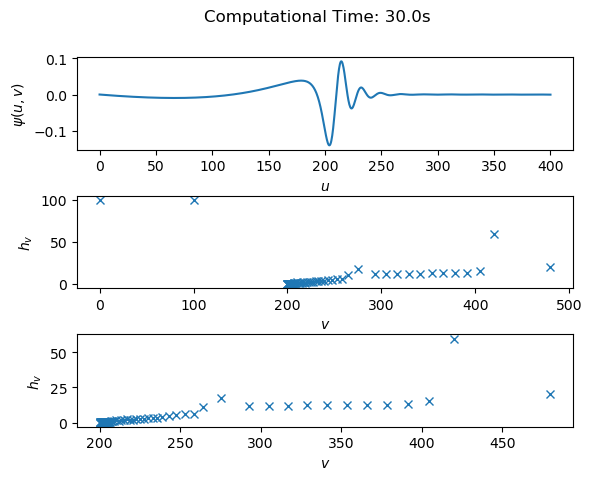

In [5]:
time = @elapsed ψ, u, v = uv_adaptive((0, 400), (0, 500), 0.4, 100, g, tol=1e-3, potential=:even)
hv = [v[n + 1] - v[n] for n = 1:(length(v) - 1)]
fig, axs = plt.subplots(3)
axs[1].plot(u, ψ)
axs[2].plot(v[1:(end - 1)], hv, "x")
axs[3].plot(v[3:(end - 1)], hv[3:end], "x")
axs[1].set(xlabel=L"u", ylabel=L"\psi(u,v)")
axs[2].set(xlabel=L"v", ylabel=L"h_v")
axs[3].set(xlabel=L"v", ylabel=L"h_v")
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Computational Time: $(round(time))s");

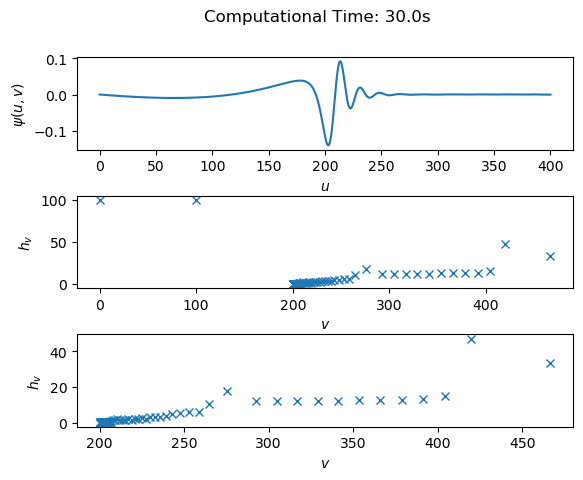

In [6]:
time = @elapsed ψ, u, v = uv_adaptive((0, 400), (0, 500), 0.4, 100, g, tol=1e-3, potential=:odd)
hv = [v[n + 1] - v[n] for n = 1:(length(v) - 1)]
fig, axs = plt.subplots(3)
axs[1].plot(u, ψ)
axs[2].plot(v[1:(end - 1)], hv, "x")
axs[3].plot(v[3:(end - 1)], hv[3:end], "x")
axs[1].set(xlabel=L"u", ylabel=L"\psi(u,v)")
axs[2].set(xlabel=L"v", ylabel=L"h_v")
axs[3].set(xlabel=L"v", ylabel=L"h_v")
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Computational Time: $(round(time))s");

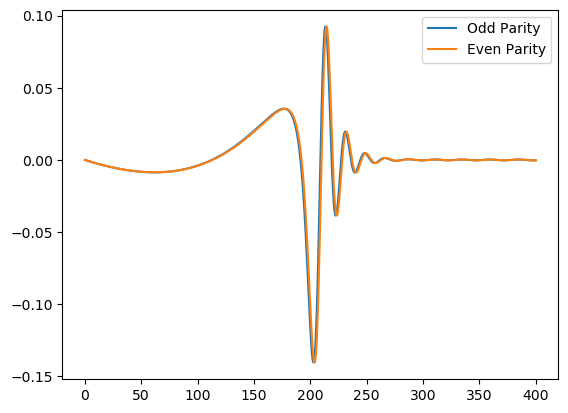

In [7]:
ψO, u, v = uv_adaptive((0, 400), (0, 600), 0.4, 100, g, tol=1e-3, potential=:odd)
ψE, u, v = uv_adaptive((0, 400), (0, 600), 0.4, 100, g, tol=1e-3, potential=:even)
plot(u, ψO, label="Odd Parity"); plot(u, ψE, label="Even Parity"); plt.legend();

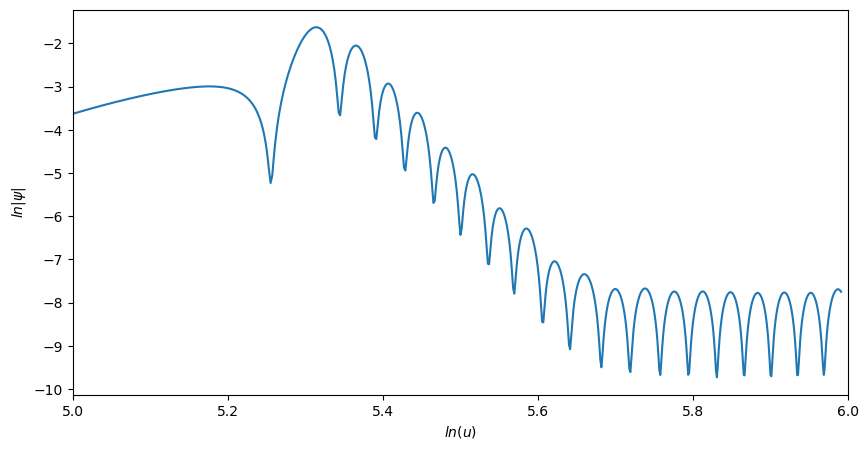

In [9]:
figure(figsize=(10, 5)); plot(log.(u), log.(abs.(complex.(ψO, ψE))))
plt.xlabel(L"ln(u)"); plt.ylabel(L"ln|ψ|"); plt.xlim(5, 6);